# Time series practicals
### GDP forecast 


In [1]:
from numpy import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook

In [2]:
data = pd.read_csv("AUD.csv", 
                    parse_dates=["Period"],
                    index_col="Period")

In [3]:

data['ln_GDP'] = np.log(data['GDP'])
data['ln_GDP_diff']= data['ln_GDP'].diff()
data = data.dropna(subset=['ln_GDP_diff'])
data.head()

,GDP,ln_GDP,ln_GDP_diff
Period,,,
1959-12-01,66501,11.104972,0.010582
1960-03-01,67357,11.117762,0.012790
1960-06-01,68245,11.130859,0.013097
1960-09-01,68854,11.139744,0.008884
1960-12-01,68977,11.141528,0.001785


### Plot log(GDP) and $\Delta log(GDP)$

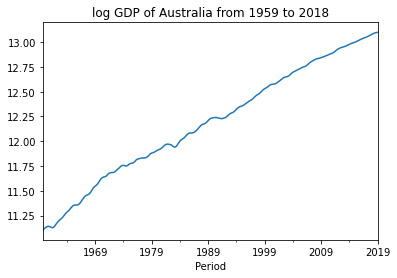

In [12]:
data.loc[:,'ln_GDP'].plot(label='Observed', color='tab:blue')
plt.title('log GDP of Australia from 1959 to 2018')
plt.show()


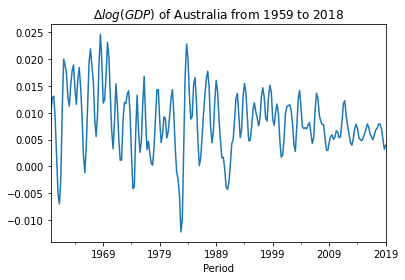

In [13]:
data.loc[:,'ln_GDP_diff'].plot(label='Observed', color='tab:blue')
plt.title('$\Delta log(GDP)$ of Australia from 1959 to 2018')
plt.show()

### Plot PACF and ACF

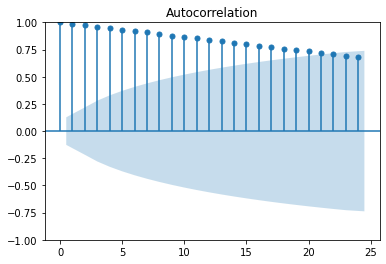

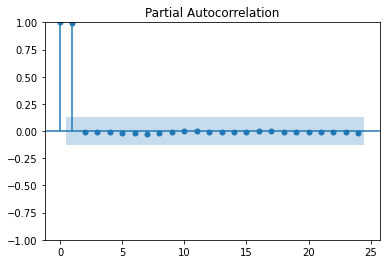

In [14]:

plot_acf(data['ln_GDP'])
plot_pacf(data['ln_GDP'])
plt.show()

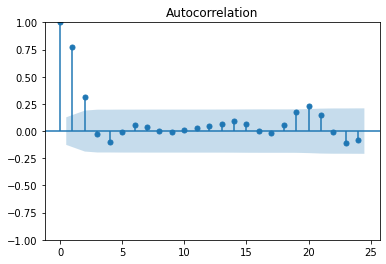

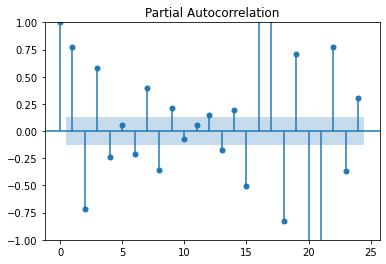

In [15]:
plot_acf(data['ln_GDP_diff'])
plot_pacf(data['ln_GDP_diff'])
plt.show()

# Augment Dickey fuller test

In [4]:


ad_fuller_result = adfuller(data['ln_GDP'])
print("ADF statistics =",ad_fuller_result[0])
print("p-value =",ad_fuller_result[1])


ADF statistics = -2.087853884377609
p-value = 0.2494265801305769


In [11]:

ad_fuller_result = adfuller(data['ln_GDP_diff'])
print("ADF statistics =",ad_fuller_result[0])
print("p-value =",ad_fuller_result[1])

ADF Statistic: -2.7685594738993635
p-value: 0.06290706245037446


### Fitting ARIMA model 

Split data into training data (the first 80\%) and test data (the last 20\%).

In [16]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
y_train = data.ln_GDP[:train_size]
y_test = data.ln_GDP[train_size:]
arima_model = ARIMA(y_train, order = (5,1,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 ln_GDP   No. Observations:                  202
Model:                 ARIMA(5, 1, 2)   Log Likelihood                 924.532
Date:                Thu, 18 Aug 2022   AIC                          -1833.064
Time:                        19:50:02   BIC                          -1806.638
Sample:                    12-01-1959   HQIC                         -1822.371
                         - 03-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3551      0.120      2.949      0.003       0.119       0.591
ar.L2          0.5320      0.158      3.372      0.001       0.223       0.841
ar.L3         -0.3201      0.096     -3.328      0.0

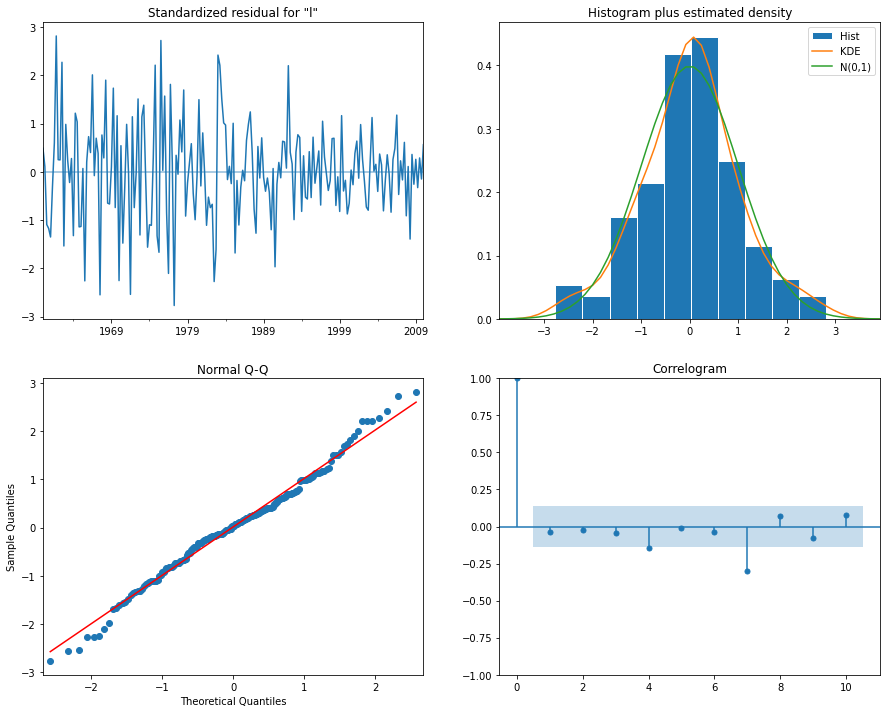

In [17]:
model.plot_diagnostics(figsize=(15,12));

### Forecasting

In [18]:
#predict = model.get_forecast(36, alpha=0.05) #95 CI forecast
#dir(predict)

predict = model.get_prediction(start=len(y_train), end=len(y_train) + len(y_test)-1)



In [19]:
predict_ci = predict.conf_int()

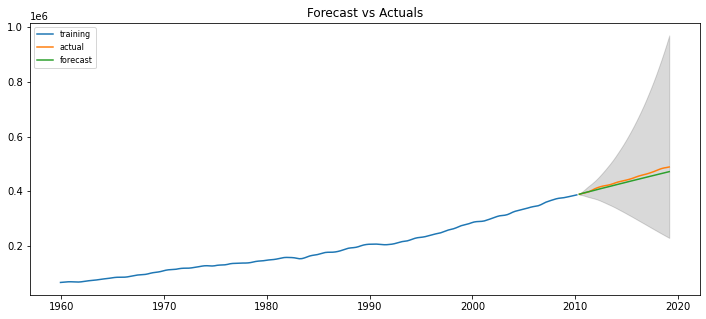

In [20]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(np.exp(y_train), label='training')
plt.plot(np.exp(y_test), label='actual')
plt.plot(np.exp(predict.predicted_mean), label='forecast')
plt.fill_between(predict_ci.index,
                 np.exp(predict_ci.iloc[:,0]),
                 np.exp(predict_ci.iloc[:,1]), color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Computing RMSE

In [21]:
RMSE = math.sqrt(mean_squared_error(np.exp(y_test), np.exp(predict.predicted_mean)))
print('Score: %.2f RMSE' % (RMSE))

Score: 10282.11 RMSE


### Hyperparameter optimisation (selecting p, q)

In [49]:
p_values = [1,3,4,5]
q_values = range(0, 4)
for p in p_values:
     for q in q_values:
            order = (p,1,q)
            warnings.filterwarnings("ignore")
            model = ARIMA(y_train, order=order).fit()
            predictions = model.predict(start=len(y_train), end=len(y_train) + len(y_test)-1)
            error = mean_squared_error(y_test, predictions)
            print('ARIMA%s MSE=%.3f' % (order,error))


ARIMA(1, 1, 0) MSE=0.010
ARIMA(1, 1, 1) MSE=0.011
ARIMA(1, 1, 2) MSE=0.012
ARIMA(1, 1, 3) MSE=0.009
ARIMA(3, 1, 0) MSE=0.006
ARIMA(3, 1, 1) MSE=0.012
ARIMA(3, 1, 2) MSE=0.005
ARIMA(3, 1, 3) MSE=0.005
ARIMA(4, 1, 0) MSE=0.006
ARIMA(4, 1, 1) MSE=0.008
ARIMA(4, 1, 2) MSE=0.012
ARIMA(4, 1, 3) MSE=0.011
ARIMA(5, 1, 0) MSE=0.005
ARIMA(5, 1, 1) MSE=0.007
ARIMA(5, 1, 2) MSE=0.001
ARIMA(5, 1, 3) MSE=0.007


# Air Passenger

<AxesSubplot:title={'center':'Number of US Airline passengers from 1949 to 1960'}, xlabel='Time', ylabel='Number of Passengers'>

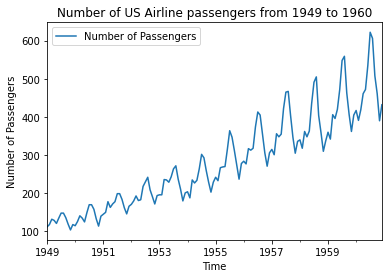

In [2]:
data = pd.read_csv('AirPassengers.csv')

data.index = pd.to_datetime(data.Month)
data.index
data.columns = ["Period","Number of Passengers"]
data.plot(title="Number of US Airline passengers from 1949 to 1960", xlabel="Time", ylabel="Number of Passengers")


In [3]:
data['ln_Pass'] = np.log(data['Number of Passengers'])
data['ln_Pass_diff']= data['ln_Pass'].diff(1)
data['ln_Pass_diff_s']= data['ln_Pass'].diff(12)

In [4]:
data1 = data.dropna()
data1.head()

,Period,Number of Passengers,ln_Pass,ln_Pass_diff,ln_Pass_diff_s
Month,,,,,
1950-01-01,1950-01,115,4.744932,-0.025752,0.026433
1950-02-01,1950-02,126,4.836282,0.091350,0.065597
1950-03-01,1950-03,141,4.948760,0.112478,0.065958
1950-04-01,1950-04,135,4.905275,-0.043485,0.045462
1950-05-01,1950-05,125,4.828314,-0.076961,0.032523


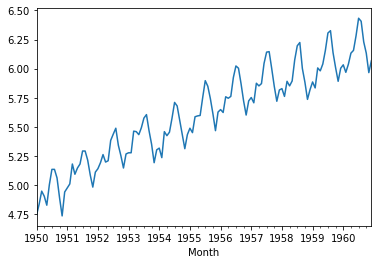

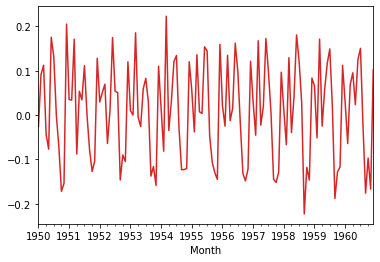

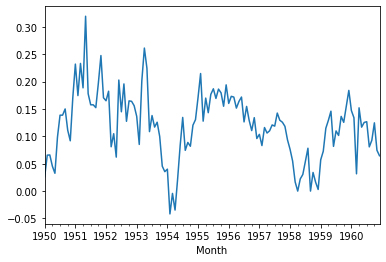

In [6]:
plt.figure()
data1.loc[:,'ln_Pass'].plot(label='log(Y)', color='tab:blue')
plt.show()
data1.loc[:,'ln_Pass_diff'].plot(label='First difference log(Y) ', color='tab:red')
plt.show()
data1.loc[:,'ln_Pass_diff_s'].plot(label='First seasonal difference log(Y)')
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
ad_fuller_result = adfuller(data1['Number of Passengers'])
print("ADF statistics =",ad_fuller_result[0])
print("p-value =",ad_fuller_result[1])

ADF statistics = 0.6881294666354515
p-value = 0.9895979711742349


In [14]:
ad_fuller_result = adfuller(data1['ln_Pass_diff'])
print("ADF statistics =",ad_fuller_result[0])
print("p-value =",ad_fuller_result[1])

ADF statistics = -3.1122901737440247
p-value = 0.025656929217050206


### Fitting ARIMA model

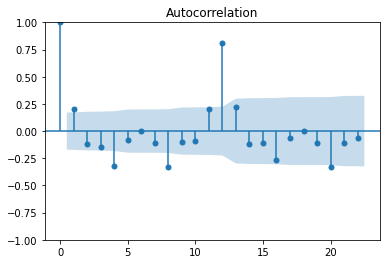

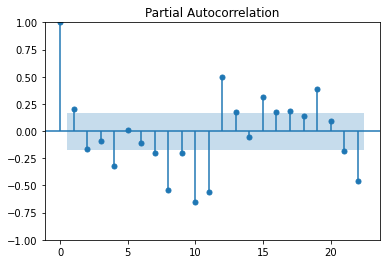

In [17]:
plot_acf(data1['ln_Pass_diff'])
plot_pacf(data1['ln_Pass_diff'])
plt.show()

In [12]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
y_train = data.ln_Pass[:train_size]
y_test = data.ln_Pass[train_size:]

In [6]:

p_values = [1,3,4,5]
q_values = range(0, 4)
for p in p_values:
     for q in q_values:
            order = (p,1,q)
            warnings.filterwarnings("ignore")
            model = ARIMA(y_train, order=order).fit()
            predictions = model.predict(start=len(y_train), end=len(y_train) + len(y_test)-1)
            error = mean_squared_error(y_test, predictions)
            print('ARIMA%s MSE=%.3f' % (order,error))


ARIMA(1, 1, 0) MSE=0.102
ARIMA(1, 1, 1) MSE=0.091
ARIMA(1, 1, 2) MSE=0.047
ARIMA(1, 1, 3) MSE=0.047
ARIMA(3, 1, 0) MSE=0.067
ARIMA(3, 1, 1) MSE=0.038
ARIMA(3, 1, 2) MSE=0.043
ARIMA(3, 1, 3) MSE=0.021
ARIMA(4, 1, 0) MSE=0.043
ARIMA(4, 1, 1) MSE=0.048
ARIMA(4, 1, 2) MSE=0.036
ARIMA(4, 1, 3) MSE=0.034
ARIMA(5, 1, 0) MSE=0.044
ARIMA(5, 1, 1) MSE=0.042
ARIMA(5, 1, 2) MSE=0.036
ARIMA(5, 1, 3) MSE=0.036


In [26]:
arima_model = ARIMA(y_train, order = (3,1,3))
model = arima_model.fit()
print(model.summary())
predict = model.get_prediction(start=len(y_train), end=len(y_train) + len(y_test)-1)

predict_ci = predict.conf_int()

                               SARIMAX Results                                
Dep. Variable:                ln_Pass   No. Observations:                  119
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 121.606
Date:                Thu, 11 Aug 2022   AIC                           -229.212
Time:                        13:06:40   BIC                           -209.818
Sample:                    01-01-1950   HQIC                          -221.338
                         - 11-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8489      0.089      9.510      0.000       0.674       1.024
ar.L2          0.4570      0.139      3.290      0.001       0.185       0.729
ar.L3         -0.7904      0.089     -8.888      0.0

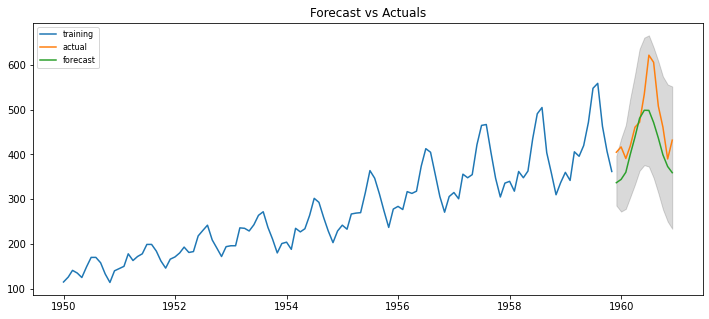

In [27]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(np.exp(y_train), label='training')
plt.plot(np.exp(y_test), label='actual')
plt.plot(np.exp(predict.predicted_mean), label='forecast')
plt.fill_between(predict_ci.index,
                 np.exp(predict_ci.iloc[:,0]),
                 np.exp(predict_ci.iloc[:,1]), color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

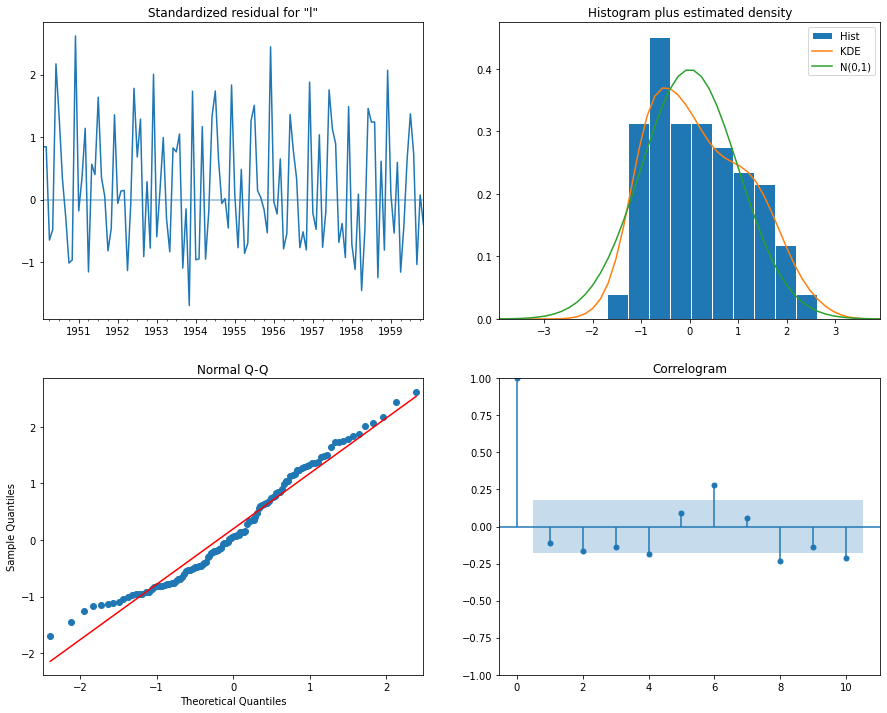

In [28]:
model.plot_diagnostics(figsize=(15,12));

### Fitting SARIMA model



In [5]:
#Thanks to https://github.com/marcopeix/time-series-analysis/blob/master/Advanced%20modelling/SARIMA.ipynb

def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df




In [7]:


p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))



16


In [8]:


result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data1['ln_Pass'])
result_df



  0%|          | 0/16 [00:00<?, ?it/s]

/home/tri083/Dropbox/TEACHING/MA3832/SP2_2022/Practicals/Code/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tri083/Dropbox/TEACHING/MA3832/SP2_2022/Practicals/Code/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tri083/Dropbox/TEACHING/MA3832/SP2_2022/Practicals/Code/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tri083/Dropbox/TEACHING/MA3832/SP2_2022/Practicals/Code/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  se

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 1, 1)",-220.944159
1,"(0, 1, 1, 1)",-220.872521
2,"(1, 0, 1, 1)",-220.322469
3,"(0, 0, 1, 1)",-217.324852
4,"(1, 1, 0, 1)",-205.827420
5,"(0, 1, 0, 1)",-199.955630
6,"(1, 0, 0, 1)",-199.099120
7,"(0, 0, 0, 1)",-194.866828
8,"(1, 1, 1, 0)",-136.018581
9,"(0, 1, 1, 0)",-118.691922


In [13]:
best_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
print(best_model.summary())



/home/tri083/Dropbox/TEACHING/MA3832/SP2_2022/Practicals/Code/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tri083/Dropbox/TEACHING/MA3832/SP2_2022/Practicals/Code/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61213D+00    |proj g|=  1.69871D+00

At iterate    5    f= -1.62495D+00    |proj g|=  3.73135D+00

At iterate   10    f= -1.64045D+00    |proj g|=  4.49994D-02

At iterate   15    f= -1.64098D+00    |proj g|=  1.92401D-01

At iterate   20    f= -1.64154D+00    |proj g|=  1.50628D-01

At iterate   25    f= -1.64339D+00    |proj g|=  9.59360D-02

At iterate   30    f= -1.64346D+00    |proj g|=  1.06146D-02

At iterate   35    f= -1.64348D+00    |proj g|=  1.27572D-01

At iterate   40    f= -1.64373D+00    |proj g|=  2.18796D-01

At iterate   45    f= -1.64385D+00    |proj g|=  4.17184D-02

At iterate   50    f= -1.64425D+00    |proj g|=  2.30384D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/tri083/Dropbox/TEACHING/MA3832/SP2_2022/Practicals/Code/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
print(best_model.summary())
predict = best_model.get_prediction(start=len(y_train), end=len(y_train) + len(y_test)-1)

predict_ci = predict.conf_int()

                                     SARIMAX Results                                      
Dep. Variable:                            ln_Pass   No. Observations:                  119
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 195.666
Date:                            Thu, 11 Aug 2022   AIC                           -381.331
Time:                                    17:20:37   BIC                           -368.014
Sample:                                01-01-1950   HQIC                          -375.934
                                     - 11-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1927      0.281     -0.686      0.493      -0.743       0.358
ma.L1         -0.1505      0.300   

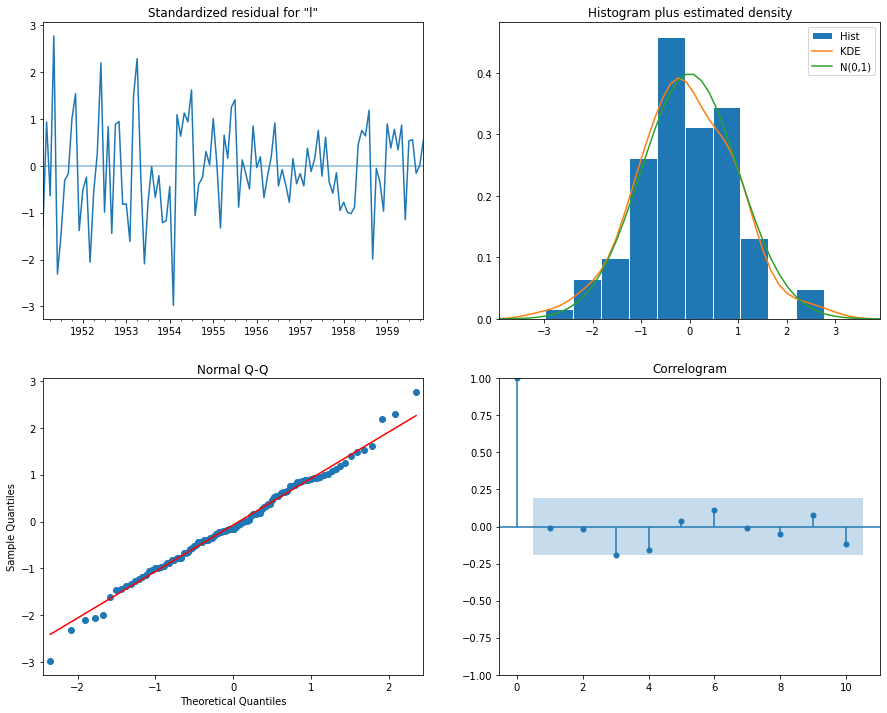

In [17]:
best_model.plot_diagnostics(figsize=(15,12));

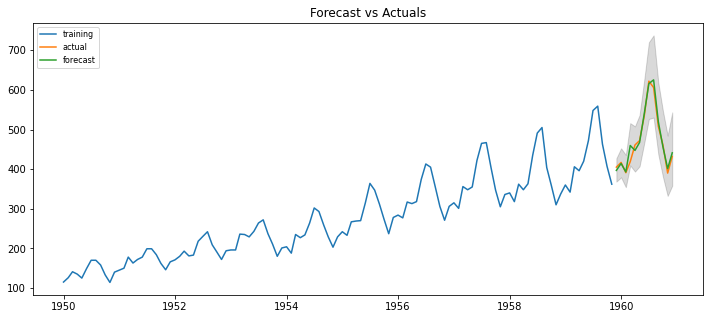

In [18]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(np.exp(y_train), label='training')
plt.plot(np.exp(y_test), label='actual')
plt.plot(np.exp(predict.predicted_mean), label='forecast')
plt.fill_between(predict_ci.index,
                 np.exp(predict_ci.iloc[:,0]),
                 np.exp(predict_ci.iloc[:,1]), color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()